In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import *
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()
from taurex.cache import OpacityCache,CIACache

In [2]:
# Paths for data
xsec_path = "../../data/atmosphere/xsecs"
cia_path = "../../data/atmosphere/cia/hitran"
phoenix_path = "../../data/atmosphere/phoenix/BT-Settl_M-0.0a+0.0"

#importing crossections
OpacityCache().clear_cache()
OpacityCache().set_opacity_path(xsec_path)
CIACache().set_cia_path(cia_path)

***Building Model***

In [16]:
#(parameters: https://exoplanetarchive.ipac.caltech.edu/overview/WASP-39%20b#planet_WASP-39-b_collapsible)
#Atmospheric model
# Temperature profile
temperature_value = 1166.0  # Kelvin (Teq for isothermal)
#guillot
from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=temperature_value) #?????

#isothermal
from taurex.temperature import Isothermal
isothermal = Isothermal(T=temperature_value) #Teq

#Planet
# Planetary parameters
planet_radius = 1.27  # in Jupiter radii
planet_mass = 0.275  # in Jupiter masses
from taurex.planet import Planet
planet = Planet(planet_radius=planet_radius,planet_mass=planet_mass)

#star
# Stellar parameters
star_temperature = 5400.0  # Kelvin
star_radius = 0.895  # in Solar radii

from taurex.stellar import BlackbodyStar
from taurex.stellar import PhoenixStar
star = BlackbodyStar(temperature=star_temperature,radius=star_radius) #ideal blackbody
anotherstar = PhoenixStar(phoenix_path=phoenix_path,
                          temperature=star_temperature,radius=star_radius) #considering stellar atmosphere

#chemistry
fill_gases = ['H2', 'He']
ratio = 0.172

gas_names = ['H2O', 'CH4', 'CO2', 'CO']
#Main components
from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=fill_gases,ratio=ratio)

#others

# Set a random seed for reproducibility
np.random.seed(45)

# Create random values for the abbundances
basis = np.round(np.random.uniform(0, 10, 4),3)  # 4 random numbers between 0 and 10
exponent = -np.random.randint(3, 8, 4)   # 4 random integers between 2 and 8 (inclusive)

mix_ratio = [basis[0]*10.0**(exponent[3]),
             basis[1]*10.0**(exponent[2]),
             basis[2]*10.0**(exponent[1]),
             basis[3]*10.0**(exponent[0])]

print('*************************\n'
    f'Random mixing ratios:\n'
      f'{gas_names[0]}: {mix_ratio[0]:.3e}\n'
      f'{gas_names[1]}: {mix_ratio[1]:.3e}\n'
      f'{gas_names[2]}: {mix_ratio[2]:.3e}\n'
      f'{gas_names[3]}: {mix_ratio[3]:.3e}\n'
      '*************************')

from taurex.chemistry import ConstantGas
h2o = ConstantGas(gas_names[0],mix_ratio=mix_ratio[0])
chemistry.addGas(h2o)
ch4 = ConstantGas(gas_names[1],mix_ratio=mix_ratio[1])
chemistry.addGas(ch4)
co2 = ConstantGas(gas_names[2],mix_ratio=mix_ratio[2])
chemistry.addGas(co2)
co = ConstantGas(gas_names[3],mix_ratio=mix_ratio[3])
chemistry.addGas(co)

#all toghether
temperature_type = "isothermal"
# Pressure profile
atm_min_pressure = 1e-0  # bar
atm_max_pressure = 1e6  # bar
nlayers = 30

from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=anotherstar,
                        atm_min_pressure=atm_min_pressure,
                       atm_max_pressure=atm_max_pressure,
                       nlayers=nlayers)

*************************
Random mixing ratios:
H2O: 9.890e-03
CH4: 5.495e-04
CO2: 2.814e-07
CO: 7.730e-07
*************************


In [17]:
# Model type
model_type = "transmission"

#physical phenomena
#absorption
from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

#CIA (collisional induced absorption)
from taurex.contributions import CIAContribution
# Contributions
cia_pairs = ['H2-H2', 'H2-He']
tm.add_contribution(CIAContribution(cia_pairs=cia_pairs))

#scattering
from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

tm.build()

In [18]:
#running the model
res = tm.model()

In [20]:
print(res)

(array([  199.99326855,   200.00660143,   200.01993521, ...,
       33328.88933329, 33331.11125925, 33333.33333333]), array([0.02872188, 0.02870498, 0.0277925 , ..., 0.02525   , 0.02525017,
       0.02525033]), array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        8.23120671e-014, 8.18593154e-014, 8.20384160e-014],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        5.66455126e-006, 5.64223249e-006, 5.65407602e-006],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.46936678e-226, 1.26124138e-226, 1.08744903e-226],
       ...,
       [4.11626316e-004, 1.19526475e-003, 6.69383361e-001, ...,
        9.94588686e-001, 9.94587078e-001, 9.94585537e-001],
       [1.13557926e-002, 2.10734289e-002, 8.13617121e-001, ...,
        9.96976385e-001, 9.96975486e-001, 9.96974623e-001],
       [1.43212452e-001, 1.87291984e-001, 9.14933638e-001, ...,
        9.98686360e-001, 9.98685969e-001, 9.98685594e-001]]), None)


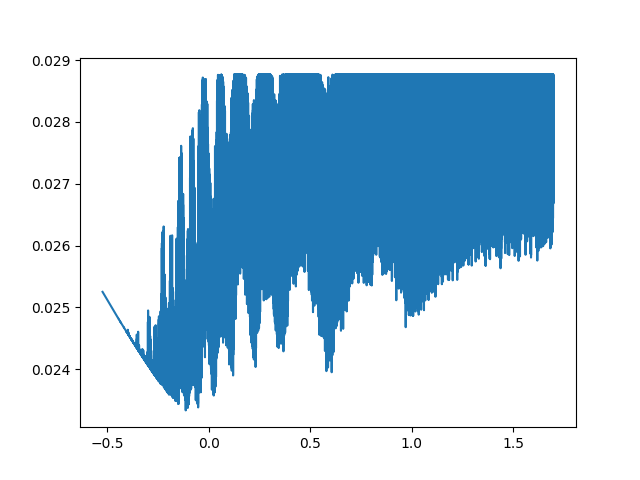

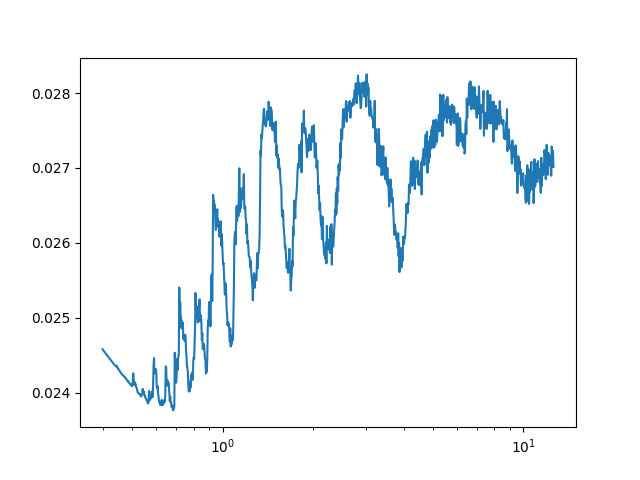

In [22]:
native_grid, rprs, tau, _ = res

full_fig = plt.figure()
plt.plot(np.log10(10000/native_grid),rprs)
plt.show()

from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.show()

Formatted parameters file saved as: WASP-39b_assignment3_taskA_parameters.txt


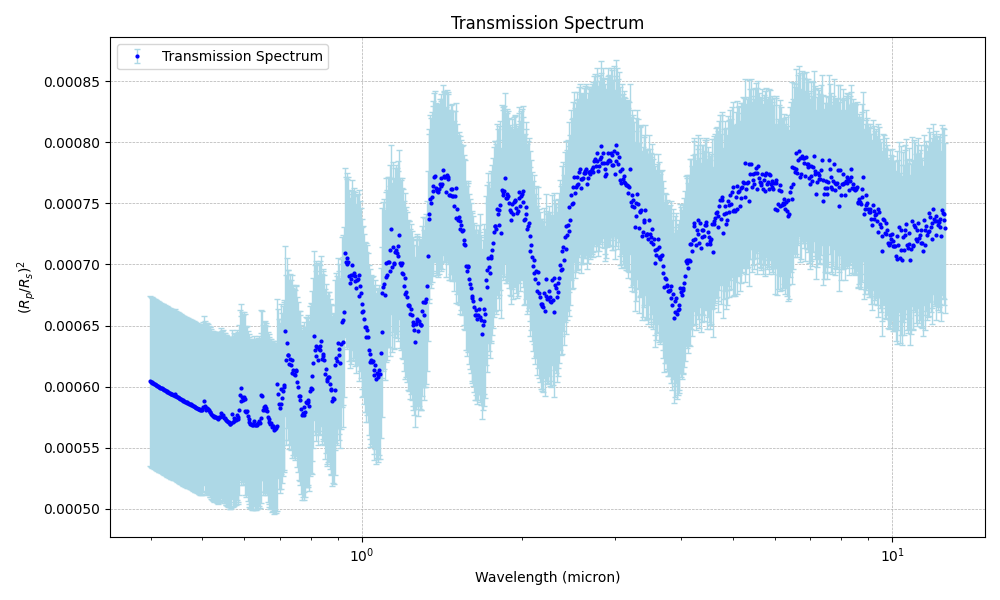

Transmission spectrum plot saved as: WASP-39b_assignment3_taskA_spectrum.png


In [23]:
# Define planet name for filenames
planet_name = "WASP-39b"

# Generate and save the spectrum data
spectrum_file = f"{planet_name}_assignment3_taskA_spectrum.dat"
parameters_file = f"{planet_name}_assignment3_taskA_parameters.txt"

# Write the spectrum data
wavelength = 10000 / bin_wn  # Convert wavenumber to microns
rprs_squared = bin_rprs**2
rprs_error = np.zeros(len(rprs_squared)) + np.std(rprs_squared)
#rprs_error = np.sqrt(rprs_squared)

spectrum_data = np.column_stack((wavelength, rprs_squared, rprs_error))
np.savetxt(spectrum_file, spectrum_data, header="wavelength(micron) (rp/rs)^2 std((rp/rs)^2)", fmt="%.8e")

# Save forward model parameters
# Define the parameters file name
parameters_file_formatted = parameters_file

# Create the formatted file content
with open(parameters_file_formatted, "w") as param_file:

    # Model section
    param_file.write("#Model\n")
    param_file.write("Global:\n")
    param_file.write(f"  xsec_path: {xsec_path}\n")
    param_file.write(f"  cia_path: {cia_path}\n")
    param_file.write(f"  phoenix_path: {phoenix_path}\n")
    param_file.write(f"  output_file: {spectrum_file} \n\n")

    param_file.write("Model:\n")
    param_file.write("  type: transmission # Può essere \"trasmission\" o \"emission\" o \"direct_image\"\n\n")

    # Atmospheric model
    param_file.write("Atmospheric_model:\n")
    param_file.write(f"  type: {temperature_type}  # Può essere \"isothermal\" o \"guillot\"\n")
    param_file.write("  parameters:\n")
    param_file.write(f"    T: {temperature_value} #K\n\n")

    # Planet section
    param_file.write("Planet:\n")
    param_file.write(f"  planet_radius: {planet_radius} #Rj\n")
    param_file.write(f"  planet_mass: {planet_mass} #Mj\n\n")

    # Star section
    star_type = "phoenix" if isinstance(star, PhoenixStar) else "blackbody"
    param_file.write("Star:\n")
    param_file.write(f"  type: {star_type} # Può essere \"blackbody\" o \"phoenix\"\n")
    param_file.write("  parameters:\n")
    param_file.write(f"    radius: {star_radius} #Rsun\n")
    param_file.write(f"    temperature: {star_temperature} #K\n\n")

    # Chemistry section
    param_file.write("Chemistry:\n")
    param_file.write("  main_species:\n")
    param_file.write(f"    fill_gases: {fill_gases}\n")
    param_file.write(f"    ratio: {ratio}\n")
    param_file.write("  other_molecules:\n")
    for name, ratio in zip(gas_names, mix_ratio):
        param_file.write(f"    {name}:\n")
        param_file.write("      gas_type: constant\n")
        param_file.write(f"      mix_ratio: {ratio}\n")
    param_file.write("\n")

    # Pressure section
    param_file.write("Pressure:\n")
    param_file.write(f"  atm_min_pressure: {atm_min_pressure}  # bar\n")
    param_file.write(f"  atm_max_pressure: {atm_max_pressure}  # bar\n")
    param_file.write(f"  nlayers: {nlayers}\n\n")

    # Physical processes
    param_file.write("Model:\n")
    param_file.write("  type: transmission # Può essere \"trasmission\" o \"emission\" o \"direct_image\"\n")
    param_file.write("  physical_processes:\n")
    param_file.write("      Absorption: True  # Attiva/disattiva il contributo di assorbimento\n")
    param_file.write("      CIA:\n")
    param_file.write("        enabled: True  # Attiva/disattiva il contributo CIA\n")
    param_file.write("        pairs:\n")
    for pair in cia_pairs:
        param_file.write(f"          - {pair}\n")
    param_file.write("      Rayleigh: True  # Attiva/disattiva il contributo Rayleigh\n")

print(f"Formatted parameters file saved as: {parameters_file_formatted}")



# Plotting the transmission spectrum
plt.figure(figsize=(10, 6))
plt.errorbar(
    wavelength, rprs_squared, yerr=rprs_error, fmt='o', color='blue', markersize=2, 
    ecolor='lightblue', elinewidth=1, capsize=2, label="Transmission Spectrum"
)
plt.xscale('log')
plt.xlabel("Wavelength (micron)")
plt.ylabel("$(R_p/R_s)^2$")
plt.title("Transmission Spectrum")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("WASP-39b_assignment3_taskA_spectrum_scatter.png")
plt.show()

print("Transmission spectrum plot saved as: WASP-39b_assignment3_taskA_spectrum.png")


***Retrival - TASK C & D***

In [9]:
from taurex.optimizer.nestle import NestleOptimizer
opt = NestleOptimizer(num_live_points=50)
#list of possible parameters that we can retrive from this model
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'atm_min_pressure',
 'atm_max_pressure',
 'T',
 'H2O',
 'CH4',
 'CO2',
 'CO',
 'He_H2']

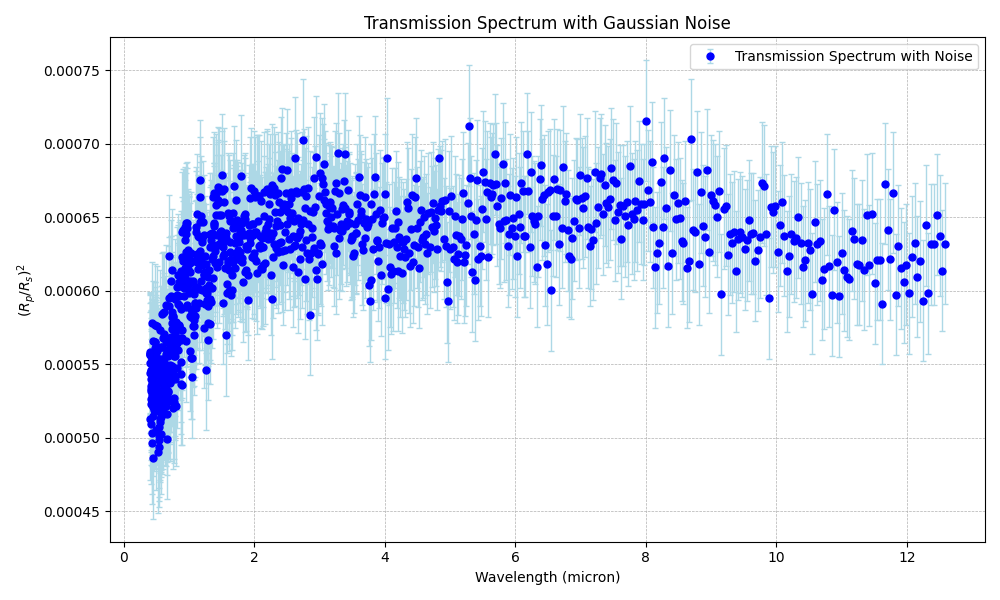

In [10]:
from taurex.data.spectrum.observed import ObservedSpectrum
#adding gaussian noise to the artificial spectrum
noise = np.random.normal(loc=0.0, scale=rprs_error*0.5, size=len(rprs_squared))

obs_flux = rprs_squared + noise

# Plot 
plt.figure(figsize=(10, 6))
plt.errorbar(
    wavelength, obs_flux, yerr=rprs_error, fmt='o', color='blue', markersize=5,
    ecolor='lightblue', elinewidth=1, capsize=2, label="Transmission Spectrum with Noise"
)
plt.xlabel("Wavelength (micron)")
plt.ylabel("$(R_p/R_s)^2$")
plt.title("Transmission Spectrum with Gaussian Noise")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()

plt.show()


#saving the noisy spectrum in a file .dat

spectrum_data = np.column_stack((wavelength, obs_flux, rprs_error))
np.savetxt('artificial_noise_spectrum.dat', spectrum_data, header="wavelength(micron) (rp/rs)^2 std((rp/rs)^2)", fmt="%.8e")




In [11]:
#obs = ObservedSpectrum('artificial_noise_spectrum.dat')
obs = ObservedSpectrum('WASP-39b_assignment3_taskA_spectrum.dat')
#binned for plotting
obin = obs.create_binner()

opt.set_model(tm)
opt.set_observed(obs)

In [12]:
#Choosing the parameters to fit and the boudaries

opt.enable_fit('planet_radius')
opt.enable_fit('T')
opt.set_boundary('T',[1000,2000])
opt.set_boundary('planet_radius',[0.8,2.0])

In [14]:
#retrival
solution = opt.fit()
taurex.log.disableLogging()

it=  1431 logz=-21497234.81132675

LinAlgError: Singular matrix

In [ ]:
for solution,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
    plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
    plt.legend()
    plt.show()